# ATT Credit Rating in IVR

by `Xiaoli Qiu`

created: `2022-04-05`

Jira: [ONE-8718](https://clearlink.atlassian.net/browse/ONE-8718).

We’ve continued to ask ATT  callers to rate their credit. Let’s see if there is any value to the data or if we can abandon that question in the IVR. <br>
<br>

## Executive Summary
- Credit rating does not seem to be independent of conversion.
- Credit rating does't add much (if any) value to the models (trained with various combinaitons of attributes).
- Credit rating does not seem to be independent of intent and max_speed either. 

__We're good to remove the credit question in IVR.__

<br>

The `route_id` needed: 

| route_id     | description             | 
| ------------ | ----------------------- |
| 716          | Rate Credit - 1 (worst) |
| 717          | Rate Credit - 2         |
| 718          | Rate Credit - 3         |
| 719          | Rate Credit - 4         |
| 720          | Rate Credit - 5 (best)  |

<br>

## TOC
- [Independence Test](#correlation)
- [Training with Different Attributes](#training)
- [TL;DR](#tldr)

In [94]:
import datetime
print('Last time updated: ', datetime.datetime.now())

Last time updated:  2022-04-06 10:08:10.350233


In [2]:
import pandas as pd
import numpy as np 

In [3]:
import matplotlib.pyplot as plt  
plt.style.use('dark_background')
import seaborn as sns
%matplotlib inline

In [91]:
from scipy.stats import chi2_contingency 
from scipy.stats import chi2
from itertools import combinations

In [5]:
def chi_square_test(df):
    """
    Function for performing chi-square test.
    :param df: targe dataframe
    :return: (1) chi-square values in dataframe and (2) p-values in dataframe. The columns names and index are the same. 
    """
    cols = list(df.columns)
    resultant_p = pd.DataFrame(data=[(0 for i in range(len(cols))) for i in range(len(cols))], 
                         columns=cols)
    resultant_p.set_index(pd.Index(cols), inplace = True)
    resultant_chi = resultant_p.copy(deep=True)

    # Finding p_value for all columns and putting them in the resultant matrix
    for i in cols:
        for j in cols:
            if i != j:
                chi2_val, p_val, _, _ = chi2_contingency(pd.crosstab(df[i], df[j]))
#                 chi2_val, p_val = chi2(np.array(df[i]).reshape(-1, 1), np.array(df[j]).reshape(-1, 1))
                resultant_p.loc[i,j] = p_val
                resultant_chi.loc[i,j] = chi2_val
                
    return tuple([resultant_chi, resultant_p])


In [6]:
import psycopg2

In [8]:
con = psycopg2.connect(dbname = 'datawarehouse', host ='dw_prod.clearlinkdata.com', 
                       port = '5439', user = username, password = password)

# con = psycopg2.connect(dbname = 'datawarehouse_stage', host ='dw_stage.clearlinkdata.com', 
#                        port = '5439', user = username, password = password)

In [ ]:
get_conv_training_set = """
SELECT date_prequeue, contact_id, brand_skilled, intent_lookup_flag, consent_flag, 
    CASE WHEN channel = 'Pay Per Click' THEN 1 ELSE 0 END       AS channel_is_ppc, marketing_tier, 
    is_weekday, max_speed_qual, is_converted
FROM data_warehouse.call_detail_attribute_log
WHERE brand_skilled IN {brands_skilled} 
AND date_prequeue >= '{train_start_date}'
AND date_prequeue <= '{train_end_date}'
AND max_speed_qual in {valid_speeds}
AND call_conclusion = 'Answered'
ORDER BY 1;
"""

get_revenue_training_set = """
SELECT
*
FROM (
(SELECT date_prequeue,
       contact_id,
       brand_skilled,
       intent_lookup_flag,
       consent_flag,
       CASE WHEN channel = 'Pay Per Click' THEN 1 ELSE 0 END                       AS channel_is_ppc,
       cdal.marketing_tier,
       is_weekday,
       max_speed_qual,
       is_converted,
       cdal.sku,
       cdal.unit_count,
       lfk.revenue
FROM data_warehouse.call_detail_attribute_log cdal
         LEFT JOIN data_warehouse.lookup_finance_kpi_sku_revenue_latest lfk
                   ON cdal.sku = lfk.sku AND cdal.brand_marketed = lfk.brand_marketed
                       AND cdal.brand_ordered = lfk.brand_ordered AND
                      cdal.financial_sale_creation_type = lfk.financial_sale_creation_type AND
                      cdal.is_overflow = lfk.is_overflow AND cdal.marketing_tier=lfk.marketing_tier
WHERE cdal.brand_ordered IN ('EMBC', 'QWEC', 'EMB', 'QWE')
AND brand_skilled IN {brands_skilled}
AND date_prequeue >= '{train_start_date}'
AND date_prequeue <= '{train_end_date}'
AND max_speed_qual in {valid_speeds}
AND is_converted = 1
AND call_conclusion = 'Answered'
ORDER BY 1,2)
UNION
(SELECT date_prequeue,
       contact_id,
       brand_skilled,
       intent_lookup_flag,
       consent_flag,
       CASE WHEN channel = 'Pay Per Click' THEN 1 ELSE 0 END                       AS channel_is_ppc,
       cdal.marketing_tier,
       is_weekday,
       max_speed_qual,
       is_converted,
       cdal.sku,
       cdal.unit_count,
       lfk.revenue
FROM data_warehouse.call_detail_attribute_log cdal
         LEFT JOIN data_warehouse.lookup_finance_kpi_sku_revenue_latest lfk
                   ON cdal.sku = lfk.sku AND cdal.brand_marketed = lfk.brand_marketed
                       AND cdal.brand_ordered = lfk.brand_ordered AND
                      cdal.financial_sale_creation_type = lfk.financial_sale_creation_type AND
                      cdal.is_overflow = lfk.is_overflow
WHERE cdal.brand_ordered NOT IN ('EMBC', 'QWEC', 'EMB', 'QWE')
AND brand_skilled IN {brands_skilled}
AND date_prequeue >= '{train_start_date}'
AND date_prequeue <= '{train_end_date}'
AND max_speed_qual in {valid_speeds}
AND is_converted = 1
AND call_conclusion = 'Answered'
ORDER BY 1,2));
"""

get_online_aq_contact_ids = """
SELECT DISTINCT cd.contact_id
FROM data_warehouse.call_detail cd
 JOIN data_warehouse.call_detail_rel_ivr_routes cdr ON cdr.contact_id = cd.contact_id
 LEFT JOIN data_warehouse.lookup_cd_ivr_route_ids lcr ON cdr.lookup_cd_ivr_route_ids_id = lcr.id
WHERE lcr.id IN (691, 746)
AND brand_skilled IN {brands_skilled}
AND DATE(cd.date_prequeue_start) >= '{train_start_date}'
AND DATE(cd.date_prequeue_start) <= '{train_end_date}'
AND call_type = 'I'
AND call_purpose = 'Sales'
AND call_conclusion = 'Answered';
"""

In [40]:
def create_training_set(train_set_conv, train_set_revenue, marketing_groups, online_aq_ids, revenue_limit, cur_date, train_days):
    """
    Function to create training sets for conversion and revenue models
    :param train_set_conv: conversion training set df
    :param train_set_revenue: revenue training set df
    :param marketing_groups: grouped marketing tiers
    :param online_aq_ids: online AQS ids to be excluded
    :param revenue_limit: revenue limits for revenue training set
    :param cur_date: current date
    :param train_days: number of most recent calendar days to be included in the training set
    :return: processed row training set
    """
    # Select appropriate dates for traninig
    train_set_conv['date_prequeue'] = pd.to_datetime(train_set_conv['date_prequeue'])
    train_set_revenue['date_prequeue'] = pd.to_datetime(train_set_revenue['date_prequeue'])
    
    end = datetime.datetime.strptime(cur_date, '%Y-%m-%d').date()
    begin = (end - pd.offsets.Day(train_days)).date()
    
    train_set_conv_dates = train_set_conv[(train_set_conv['date_prequeue'].dt.date <= end) & (train_set_conv['date_prequeue'].dt.date >= begin)]
    train_set_revenue_dates = train_set_revenue[(train_set_revenue['date_prequeue'].dt.date <= end) & (train_set_revenue['date_prequeue'].dt.date >= begin)]
    
    train_set_conv_processed = process_training_set(train_set_conv_dates, marketing_groups, online_aq_ids)
    train_set_revenue_processed = process_rev_training_set(train_set_revenue_dates, revenue_limit, marketing_groups, online_aq_ids)
    
    return tuple([train_set_conv_processed, train_set_revenue_processed])

def process_training_set(train_set, marketing_groups, online_aq_ids):
    """
    Function to build rows for the training set
    :param train_set: training set data frame
    :return: processed row training set
    """
    # logging.info('Number of records: ')
    # logging.info(train_set.shape[0])
    train_set = train_set[~train_set['contact_id'].astype(int).isin(online_aq_ids['contact_id'].astype(int))].copy()
    # logging.info('Number of records after removing online address qual: ')
    # logging.info(train_set.shape[0])

    if marketing_groups is not None:
        train_set['marketing_tier'] = train_set['marketing_tier'].map(marketing_groups)
        train_set['marketing_tier'].fillna('G4', inplace=True)
        # logging.info('Marketing tier ratios: ')
        # logging.info(train_set['marketing_tier'].value_counts())
        # logging.info(train_set['marketing_tier'].value_counts(normalize=True) * 100)
    else:
        train_set.loc[:, 'marketing_tier'] = 'NA'
        # logging.info(train_set['marketing_tier'].unique())

    train_set.rename(columns={'marketing_tier': 'marketing_tier_group'}, inplace=True)

    cols = ['intent_lookup_flag', 'consent_flag', 'channel_is_ppc',
            'marketing_tier_group', 'max_speed_qual', 'is_weekday']

    for c in cols:
        train_set[c] = train_set[c].astype('category')

    # logging.info('Class ratios before dropping the duplicates: ')
    # logging.info(train_set['is_converted'].value_counts())
    # logging.info(train_set['is_converted'].value_counts(normalize=True) * 100)

    train_set = train_set.sort_values('is_converted', ascending=False).drop_duplicates(subset=['contact_id'],
                                                                                       keep="first")
    train_set.dropna(subset=['marketing_tier_group'], inplace=True)

    # logging.info('Unique marketing_tier_group values after dropna: ')
    # logging.info(train_set['marketing_tier_group'].unique())

    to_drop = ['date_prequeue', 'brand_skilled', 'contact_id']
    train_set.drop(to_drop, axis=1, inplace=True)
    return train_set

def process_rev_training_set(train_set, revenue_limit, marketing_groups, online_aq_ids):
    """
    Function to build rows for the revenue training set
    :param train_set: training set data frame
    :return: processed row training set
    """
    # logging.info('Number of records: ')
    # logging.info(train_set.shape[0])
    train_set = train_set[~train_set['contact_id'].astype(int).isin(online_aq_ids['contact_id'].astype(int))].copy()
    # logging.info('Number of records after removing online address qual: ')
    # logging.info(train_set.shape[0])

    if marketing_groups is not None:
        train_set['marketing_tier'] = train_set['marketing_tier'].map(marketing_groups)
        train_set['marketing_tier'].fillna('G4', inplace=True)
        # logging.info('Marketing tier ratios: ')
        # logging.info(train_set['marketing_tier'].value_counts())
        # logging.info(train_set['marketing_tier'].value_counts(normalize=True) * 100)
    else:
        train_set.loc[:, 'marketing_tier'] = 'NA'
        # logging.info(train_set['marketing_tier'].unique())

    train_set.rename(columns={'marketing_tier': 'marketing_tier_group'}, inplace=True)

    cols = ['intent_lookup_flag', 'consent_flag', 'channel_is_ppc', 'marketing_tier_group', 'max_speed_qual',
            'is_weekday', 'sku']

    for c in cols:
        train_set[c] = train_set[c].astype('category')

    # aggregate and calculate the revenue for each contact_id
    rev_cal = train_set.assign(fkrs_revenue=train_set.eval('unit_count * revenue')).groupby(
        'contact_id', as_index=False).sum()
    rev_cal.drop(columns=['unit_count', 'revenue', 'is_converted'], inplace=True)

    train_set.drop(columns=['sku', 'unit_count', 'revenue', 'date_prequeue', 'brand_skilled'],
                   inplace=True)
    train_set.drop_duplicates(inplace=True)

    train_set = pd.merge(train_set,
                         rev_cal,
                         how='outer',
                         on='contact_id')

    train_set.dropna(subset=['marketing_tier_group', 'fkrs_revenue'], inplace=True)
    # logging.info('Unique marketing_tier_group values after dropna: ')
    # logging.info(train_set['marketing_tier_group'].unique())

    min_revenue_limit = revenue_limit[0]
    max_revenue_limit = revenue_limit[1]
    train_set = train_set[train_set['fkrs_revenue'].between(min_revenue_limit, max_revenue_limit)]

    train_set.drop(columns=['contact_id'], axis=1, inplace=True)
    return train_set

In [41]:
from statsmodels.api import add_constant
from statsmodels.api import OLS
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from itertools import product
from imblearn.over_sampling import SMOTE 

In [42]:
def build_model_oversample(train_set_conv, train_set_revenue):
    """
    Function that builds the regression model from the training set
    :param train_set_conv: training set for conversion mddel
    :param train_set_revenue: training set for revenue model
    :param brand: model brand
    :return: model objects and report
    """
    train = train_set_conv.drop(['is_converted'], axis=1)
    y = train_set_conv['is_converted']
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(train)
    
    X = encoder.transform(train)
    
    oversample = SMOTE(sampling_strategy='minority')
    X, y = oversample.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=10)

    train1 = train_set_revenue.drop(['is_converted', 'fkrs_revenue'], axis=1)
    encoder1 = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder1.fit(train1)
    X1 = encoder1.transform(train1)
    y1 = train_set_revenue['fkrs_revenue']

    # adding bias
    X1_ = np.append(X1,np.ones([len(X1),1]),1)

    model_conv = LogisticRegression(max_iter=500, random_state=10).fit(X_train, y_train)
    model_rev = (OLS(y1, X1_)).fit()

    # logging.info('Revenue model summary: ')
    # logging.info(model_rev.summary())

    print('Revenue model R2: ')
    print(model_rev.rsquared)

    print('Accuracy of Logistic Regression on training set: {:.2f}'.format(model_conv.score(X_train, y_train)))
    print('Accuracy of Logistic Regression on test set: {:.2f}'.format(model_conv.score(X_test, y_test)))

    out = model_conv.predict_proba(X)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y, out)
    beta = 1
    f_score = (1 + beta ** 2) * (precision * recall) / (beta ** 2 * precision + recall)
    ix = np.argmax(f_score)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], f_score[ix]))

    threshold = thresholds[ix]
    y_pred = np.where(out > threshold, 1, 0)

    cnv_model_report = (classification_report(y, y_pred, output_dict=True))

    print('Classification report: ')
    print(pd.DataFrame(cnv_model_report).iloc[:-1, :-2].T)

    return tuple([(model_conv, cnv_model_report), model_rev, encoder, encoder1])

In [9]:
valid_sq_speeds = [5000, 1000, 75, 50, 18, 10, 25, 100, 5, 2, 1, 0]
revenue_limit = [20, 600]
brand_skilled = ['ATT']
cur_date = '2022-02-28'

max_valid_speeds = "({valid_speeds}, 'NA')".format(valid_speeds=', '.join(map(str, ["'{x}'".format(x=x) for x in valid_sq_speeds])))
brands_skilled ="({skilled})".format(skilled=", ".join("'" + item + "'" for item in brand_skilled))

In [10]:
train_set_conv = pd.read_pickle('conv_train_set_20220301.pkl')
train_set_revenue = pd.read_pickle('rev_train_set_20220301.pkl')
online_aq_ids = pd.read_pickle('onlineAQSids_set_20220301.pkl')

In [24]:
# Get the credit ratings
cds = train_set_conv['contact_id'].unique().tolist()
contact_ids = "({contact_id})".format(contact_id=", ".join(contact_id for contact_id in cds)) 

In [26]:
get_credit_rating = """
SELECT DISTINCT cd.contact_id,
                CASE
                    WHEN lcr.id = 716 THEN 1
                    WHEN lcr.id = 717 THEN 2
                    WHEN lcr.id = 718 THEN 3
                    WHEN lcr.id = 719 THEN 4
                    WHEN lcr.id = 720 THEN 5
                    END AS credit_rating
FROM data_warehouse.call_detail cd
JOIN data_warehouse.call_detail_rel_ivr_routes cdr ON cdr.contact_id = cd.contact_id
LEFT JOIN data_warehouse.lookup_cd_ivr_route_ids lcr ON cdr.lookup_cd_ivr_route_ids_id = lcr.id
WHERE cd.contact_id IN {contact_ids}
AND lcr.id IN (716, 717, 718, 719, 720);
"""

In [27]:
df_creditrating =  pd.read_sql(get_credit_rating.format(contact_ids=contact_ids), con)

In [28]:
df_creditrating['contact_id'].nunique() / train_set_conv['contact_id'].nunique()

0.3247767067964774

Not all ATT customers go through lean IVR. Look at the ones with credit rating only.

In [33]:
train_set_conv['contact_id'] = train_set_conv['contact_id'].astype(int)
train_set_revenue['contact_id'] = train_set_revenue['contact_id'].astype(int)
df_train_conv_cr = pd.merge(train_set_conv, df_creditrating, on=['contact_id'], how='inner')
df_train_rev_cr = pd.merge(train_set_revenue, df_creditrating, on=['contact_id'], how='inner')

In [38]:
df_train_conv_cr['credit_rating'] = df_train_conv_cr['credit_rating'].astype('category')
df_train_rev_cr['credit_rating'] = df_train_rev_cr['credit_rating'].astype('category')

In [43]:
train_days = 180
train_set_conv_processed, train_set_revenue_processed = create_training_set(df_train_conv_cr, df_train_rev_cr, None, online_aq_ids, revenue_limit, cur_date, train_days)

<a id='correlation'> </a>
# Independence Test

In [49]:
[resultant_chi, resultant_p] = chi_square_test(train_set_conv_processed[['intent_lookup_flag', 'consent_flag', 'max_speed_qual', 'is_weekday', 'channel_is_ppc', 'credit_rating', 'is_converted']])

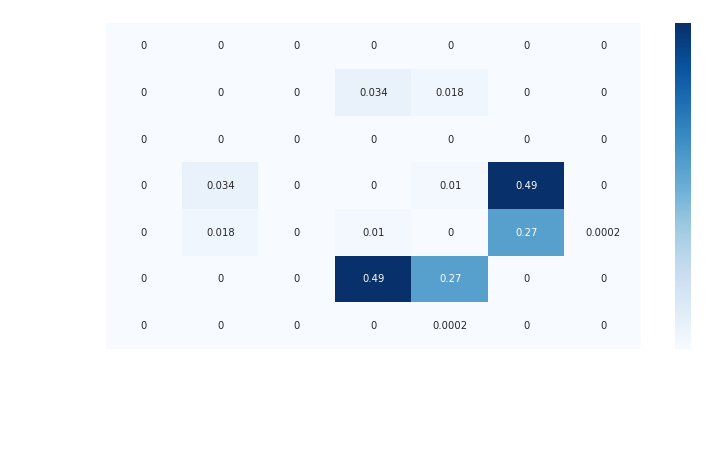

In [50]:
# Plotting p-values
fig = plt.figure(figsize=(12,6))
sns.heatmap(np.round(resultant_p,4), annot=True, cmap='Blues')
plt.title('Chi-Square Test p-values')
plt.show()

Whatever chi-values say about the association between `credit_rating` and `channel_is_ppc` as well as the association between `credit_rating` and `is_weekday` are not statistically significant.

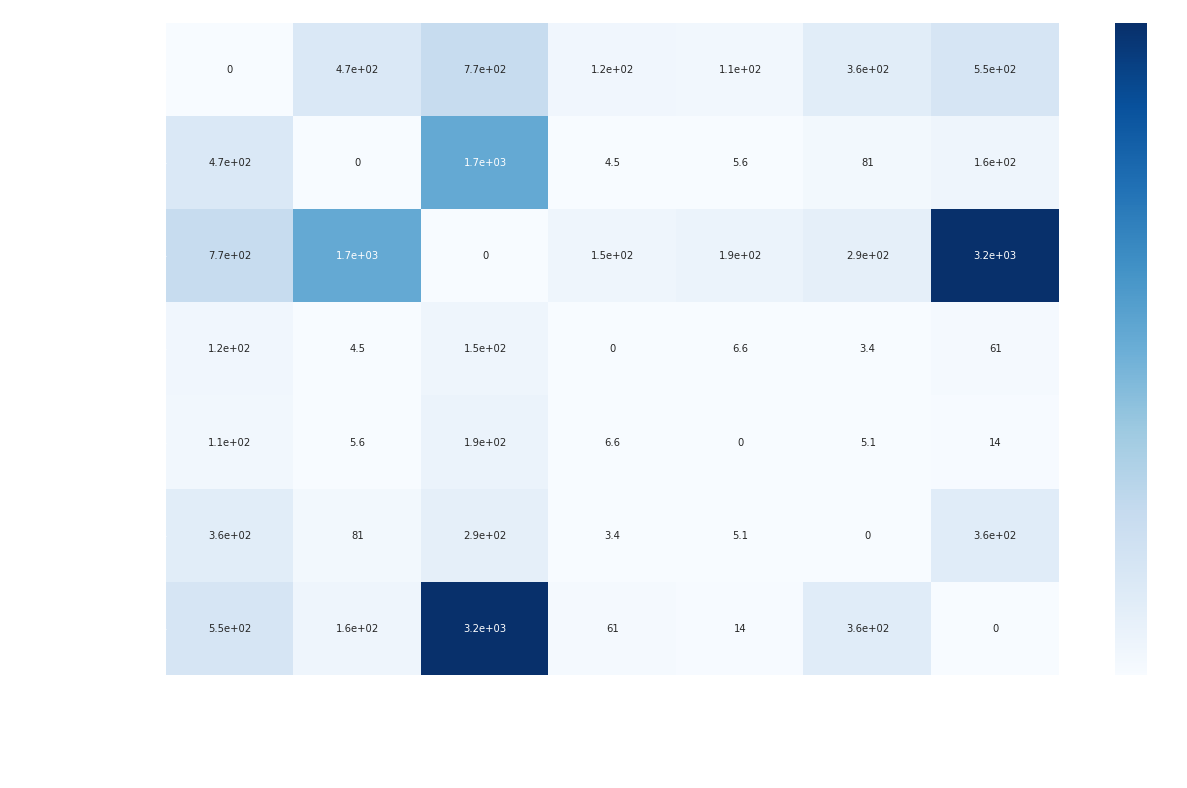

In [57]:
# Plotting chi-square values
bfig = plt.figure(figsize=(20,12))
g = sns.heatmap(resultant_chi, annot=True, cmap='Blues')
g.set_xticklabels(g.get_xticklabels(), rotation = 30, fontsize = 18)
g.set_yticklabels(g.get_yticklabels(), rotation = 30, fontsize = 18)
plt.title('Chi-Square Test chi')
plt.show()

__Observaations:__

- `credit_rating` and `is_converted` do not seem to be indenpendent of each other. 
- `credit_rating` seems to have some kind of association with `intent_lookup_flag` and `max_speed_qual` as well. 
- Also, for this subset (where credit rating exists), `consent_flag` seems to correlate less with `is_converted` compared to `intent_lookup_flag`, while generally this is not the case for ATT. 

In [92]:
contingency_conv = pd.crosstab(train_set_conv_processed['credit_rating'], train_set_conv_processed['is_converted'])

chi_v, p, dof, expected = chi2_contingency(contingency_conv)
chi2.ppf(0.95, dof)

9.487729036781154

## Look at `credit_rating` and `is_converted`

In [71]:
contingency_conv = pd.crosstab(train_set_conv_processed['credit_rating'], train_set_conv_processed['is_converted'])
contingency_conv
# observed counts

is_converted       0     1
credit_rating             
1               2107   563
2               1974   776
3               5507  2915
4               4711  3127
5              10902  5516

In [87]:
c_conv, p_conv, _, expected_conv = chi2_contingency(contingency_conv)
pd.DataFrame(expected_conv, columns=contingency_conv.columns, index=contingency_conv.index)
# Expected counts

is_converted              0            1
credit_rating                           
1               1766.147042   903.852958
2               1819.065305   930.934695
3               5570.970182  2851.029818
4               5184.666859  2653.333141
5              10860.150612  5557.849388

In [86]:
pd.DataFrame((np.asarray(contingency_conv)/expected_conv), columns=contingency_conv.columns, index=contingency_conv.index)
# Ratios between observed values and the expected values (observed/expected)

is_converted          0         1
credit_rating                    
1              1.192992  0.622889
2              1.085173  0.833571
3              0.988517  1.022438
4              0.908641  1.178518
5              1.003853  0.992470

In [85]:
pd.DataFrame(((np.asarray(contingency_conv) - expected_conv)**2/expected_conv), columns=contingency_conv.columns, index=contingency_conv.index)
# Individual components in chi value

is_converted           0           1
credit_rating                       
1              65.782031  128.539425
2              13.196206   25.785654
3               0.734555    1.435335
4              43.273811   84.557906
5               0.161266    0.315117

Those who rated themselves with lower credit are less likely to convert. 

## Look at `intent_lookup_flag` and `credit_rating`

In [80]:
contingency_intent = pd.crosstab(train_set_conv_processed['credit_rating'], train_set_conv_processed['intent_lookup_flag'])
contingency_intent
# observed counts

intent_lookup_flag    0      1     2
credit_rating                       
1                    67   2105   498
2                    33   2035   682
3                   146   6104  2172
4                   162   5290  2386
5                   529  10747  5142

In [81]:
c_intent, p_intent, _, expected_intent = chi2_contingency(contingency_intent)
pd.DataFrame(expected_intent, columns=contingency_intent.columns, index=contingency_intent.index)
# Expected counts

intent_lookup_flag           0             1            2
credit_rating                                            
1                    65.667227   1841.836054   762.496719
2                    67.634784   1897.022153   785.343063
3                   207.134600   5809.716573  2405.148827
4                   192.771432   5406.858050  2238.370518
5                   403.791958  11325.567169  4688.640874

In [82]:
pd.DataFrame((np.asarray(contingency_intent)/expected_intent), columns=contingency_intent.columns, index=contingency_intent.index)
# Ratios between observed values and the expected values (observed/expected)

intent_lookup_flag         0         1         2
credit_rating                                   
1                   1.020296  1.142881  0.653118
2                   0.487915  1.072734  0.868410
3                   0.704856  1.050654  0.903063
4                   0.840373  0.978387  1.065954
5                   1.310081  0.948915  1.096693

In [83]:
pd.DataFrame(((np.asarray(contingency_intent) - expected_intent)**2/expected_intent), columns=contingency_intent.columns, index=contingency_intent.index)
# Individual components in chi value

intent_lookup_flag          0          1          2
credit_rating                                      
1                    0.027050  37.601209  91.749266
2                   17.735966  10.035669  13.598883
3                   18.043530  14.906534  22.600837
4                    4.911936   2.525645   9.736754
5                   38.824582  29.556133  43.836690

__Observations:__

- Intent maybe is less likely to rate themselves with low credit.
- Intent no tend to rate themselves with highest credit (however, the population is small).

<a id='training'> </a>

# Training with Different Attributes

In [52]:
def keep_3_attributes_at_least(train_set_conv_processed, train_set_revenue_processed, attri_keep_list=['max_speed_qual', 'intent_lookup_flag', 'consent_flag']):
    """
    
    """
    cols = train_set_conv_processed.drop(columns=['is_converted']).columns
    f1_1_best = 0
    f1_0_best = 0
    accuracy_best = 0
    recall_1_best = 0
    cols_best = cols
    dict_save = {'f1_1_best': {'cols_best': cols_best, 'conv_model_report': None},
                'f1_0_best': {'cols_best': cols_best, 'conv_model_report': None},
                'accuracy_best': {'cols_best': cols_best, 'conv_model_report': None},
                'recall_1_best': {'cols_best': cols_best, 'conv_model_report': None},
                }

    # keeping the attributes in the attri_keep_list, add at least 1 other attribute
    cols_combs = []
    for L in range(0, len(cols)+1):
        for subset in combinations(cols, L):
            if (len(subset) >= 3) & (all(elem in subset for elem in attri_keep_list)) & ('marketing_tier_group' not in subset):    
                cols_combs.append(list(subset))
#     print(cols_combs)
                
    for cols_comb in cols_combs:
        print('-----------------')
        print('Current attributes: ', cols_comb)
        train_set_conv_processed_d = pd.concat([train_set_conv_processed[cols_comb], train_set_conv_processed['is_converted']], axis= 1)
        train_set_revenue_processed_d = pd.concat([train_set_revenue_processed[cols_comb], train_set_revenue_processed[['is_converted', 'fkrs_revenue']]], axis= 1)

        (mdl_conv_new, conv_model_report_new), mdl_rev_new, encoder_conv_new, encoder_rev_new = build_model_oversample(train_set_conv_processed_d, train_set_revenue_processed_d)
        f1_1_cur = conv_model_report_new['1']['f1-score']
        f1_0_cur = conv_model_report_new['0']['f1-score']
        accuracy_cur = conv_model_report_new['accuracy']
        recall_1_cur = conv_model_report_new['1']['recall']
        
        if (f1_1_cur > f1_1_best):
            dict_save['f1_1_best']['cols_best'] = cols_comb
            dict_save['f1_1_best']['conv_model_report'] = conv_model_report_new
            f1_1_best = f1_1_cur
        elif (f1_0_cur > f1_0_best):
            dict_save['f1_0_best']['cols_best'] = cols_comb
            dict_save['f1_0_best']['conv_model_report'] = conv_model_report_new
            f1_0_best = f1_0_cur
        elif (accuracy_cur >= accuracy_best):
            dict_save['accuracy_best']['cols_best'] = cols_comb
            dict_save['accuracy_best']['conv_model_report'] = conv_model_report_new
            accuracy_best = accuracy_cur
        elif recall_1_cur > recall_1_best: 
            dict_save['recall_1_best']['cols_best'] = cols_comb
            dict_save['recall_1_best']['conv_model_report'] = conv_model_report_new
            recall_1_best = recall_1_cur
            
    print('Best combination of attributes that yields the best accuracy if: ', dict_save['accuracy_best']['cols_best'])

    return tuple([cols_combs, dict_save])

In [55]:
all_combs, best_attritubes = keep_3_attributes_at_least(train_set_conv_processed, train_set_revenue_processed)

-----------------
Current attributes:  ['intent_lookup_flag', 'consent_flag', 'max_speed_qual']
Revenue model R2: 
0.16693656855280892
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.372212, F-Score=0.685
Classification report: 
          precision    recall  f1-score
0          0.746195  0.227610  0.348820
1          0.544305  0.922582  0.684669
accuracy   0.575096  0.575096  0.575096
-----------------
Current attributes:  ['intent_lookup_flag', 'consent_flag', 'channel_is_ppc', 'max_speed_qual']
Revenue model R2: 
0.1692998017544105
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.321194, F-Score=0.684
Classification report: 
          precision    recall  f1-score
0          0.743091  0.227253  0.348061
1          0.543881  0.921432  0.684017
accuracy   0.574342  0.574342  0.574342
-----------------
Current attributes:  ['intent_lookup_flag

In [56]:
all_combs_2, best_attritubes_2 = keep_3_attributes_at_least(train_set_conv_processed, train_set_revenue_processed, attri_keep_list=['max_speed_qual', 'intent_lookup_flag', 'credit_rating'])

-----------------
Current attributes:  ['intent_lookup_flag', 'max_speed_qual', 'credit_rating']
Revenue model R2: 
0.1688070425282081
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.331360, F-Score=0.687
Classification report: 
          precision    recall  f1-score
0          0.742870  0.263561  0.389081
1          0.552375  0.908773  0.687108
accuracy   0.586167  0.586167  0.586167
-----------------
Current attributes:  ['intent_lookup_flag', 'consent_flag', 'max_speed_qual', 'credit_rating']
Revenue model R2: 
0.1694456059500119
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.329322, F-Score=0.689
Classification report: 
          precision    recall  f1-score
0          0.738882  0.292052  0.418634
1          0.558839  0.896790  0.688584
accuracy   0.594421  0.594421  0.594421
-----------------
Current attributes:  ['intent_lookup_flag'

__Observations:__

Looking at the R2 score for revenue model and the accuracy for the conversion model, `credit_rating` is not doing much.

<a id='tldr'> </a>

# TL;DR

Though there seems to be some sort of association between `credit_rating` and `conversion`, the impact of it to the training model seems to be minimal. Which is reasonable as `credit_rating` seems to be associated with `intent` and `max_speed` as well!! 